Okay! This is the last chapter. When we finish this we finish the whole project and we are able to automatically help us with investing stocks WOW!

So this time let's make it straight forward. Note that this notebook is for better understanding, we finally need to separate our code in some python files. So let's first write the import module `module.py`

In [1]:
# module.py
import quandl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

Using TensorFlow backend.


And let's recall the data processing methods in `preprocess.py`.

There are several things need to notice, we do not need to split the data into train and validation now. Instead, we just use all the newest data as training data and use them to train the model. Then, we could make a next-90-days prediction, based on the last 60 days of data. 

In [23]:
# preprocess.py
from sklearn.preprocessing import MinMaxScaler
def get_train_and_test_data(df):    
    df['Date'] = pd.to_datetime(df.index,format='%Y-%m-%d')
    data = df.sort_index(ascending=True, axis=0)
    new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
    for i in range(0,len(data)):
        new_data['Date'][i] = data['Date'][i]
        new_data['Close'][i] = data['Close'][i]

    #setting index
    new_data.index = new_data.Date
    new_data.drop('Date', axis=1, inplace=True)

    #creating train and test sets
    dataset = new_data.values

    train = dataset
    #valid = dataset[960:,:]  
    
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)
    
    x_train, y_train = [], []
    for i in range(60,len(train)):
        x_train.append(scaled_data[i-60:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    # reshape to feed into LSTM
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
    
    '''
    inputs = new_data[len(new_data) - 90 - 60:].values
    inputs = inputs.reshape(-1,1)    
    inputs = scaler.transform(inputs)    
    
    x_test = []
    for i in range(60, inputs.shape[0]):
        x_test.append(inputs[i-60:i,0])
        
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
    '''    
    x_test = scaled_data[-60:,0]
    print ("test shape is: ", x_test.shape)        
    
    return x_train, y_train, x_test, train[-1], new_data, scaler


def test_and_plot(model, test, hist, scaler, length=90):
    res = np.zeros((length,1))
    '''
    cp = np.copy(test)
    for i in range(cp.shape[0]):
        res[i][0] = model.predict(cp[i].reshape(1, -1, 1))[0][0]
        if i < cp.shape[0] - 1:
            cp[i+1][-1][0] = res[i][0]
            # print (X_2[i+1])    

    #closing_price = model.predict(X_test)
    '''
    for i in range(length):
        res[i][0] = model.predict(test.reshape(1, -1, 1))[0][0]
        test = test[1:]
        test = np.append(test, res[i][0])    
    
    res = scaler.inverse_transform(res)
    plt.plot(hist['Close'])
    plt.show()
    plt.plot(res)
    plt.show()
    return res

In [24]:
def m(code, token):
    df = quandl.get(code, authtoken=token, start_date="2015-01-01")
    train_x, train_y, test_x, current, hist, scal = get_train_and_test_data(df)
    
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(train_x.shape[1],1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_x, train_y, epochs=4, batch_size=1, verbose=2)
    
    res = test_and_plot(model, test_x, hist, scal)

/home/litchy/Programs/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


test shape is:  (60,)
Epoch 1/4
 - 53s - loss: 0.0069
Epoch 2/4
 - 52s - loss: 0.0032
Epoch 3/4
 - 55s - loss: 0.0024
Epoch 4/4
 - 63s - loss: 0.0023


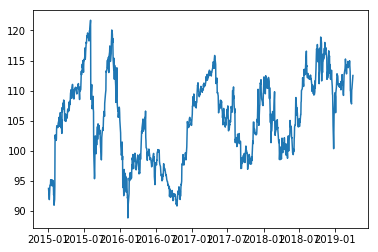

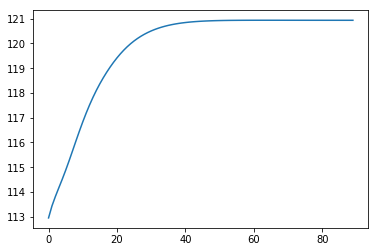

In [25]:
m("EOD/DIS", "nUnXVC-wyxYCVreWU7nY")